# NCICS ML training Tutorials E12 - Hyperparameter Tuning

This notebook demonstrate three different hyperparameter tuning techniques,  

  * Grid Search
  * Random Search
  * Bayesian Optimization
  
To better demonstrate the performance of three different techniques, we will use simulated data instead of real world data
since we know the distribution of simulated data so it can help us compare the final results.  

The simulated data is generated using a regression simulation system described in [Sapp et al. 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4000126/). 

$$y=\epsilon + x_1 + \sin(x_2) + \log(|x_3|) + x_4^2 + x_5 x_6 + I(x_7 x_8 x_9 < 0) + I(x_{10}>0) + I(x_{11} > 0) 
   \\+ \sqrt {|x_{12}|} + \cos(x_{13}) + 2x_{14} + |x_{15}| + I(x_{16}<-1) + x_{17}I(x_{17}<-1) - 2x_{18} - x_{19}x_{20}$$

This simulation system uses 20 independent Gaussian random variables with zero mean and a variance of nine 
(i.e., $x_{i} \sim N(0,9)$). The random error here is also Gaussian with zero mean and a variance of nine
(i.e., $\epsilon \sim N(0,9)$).

The simulated data is generated using the built-in `SLC14_1` function from the package `caret`. More information about 
the function can be found in this [R Documentation page](https://www.rdocumentation.org/packages/caret/versions/6.0-78/topics/SLC14_1).

In [2]:
library(caret)
## Setting seed number for reproducible results
set.seed(7210)
## Get training data
train_data <- SLC14_1(250)
large_data <- SLC14_1(1000)

We will use a radial basis function (RBF) support vector machine (SVM) to model the simulated data. For a fixed `epsilon` 
in the SVM model, the model will be tuned over the `cost` value and the radial basis kernel parameter, or `sigma`. Since 
we are simulating the data, we can figure out a good approximation to the relationship between these parameters and the 
root mean squared error (RMSE) of the model. Given our specific training set and the larger simulated sample, here is the
RMSE surface for a wide range of values:

![Figure 1. True RMSE surface](https://revolution-computing.typepad.com/.a/6a010534b1db25970b01b8d1f3992b970c-pi).

There is a wide range of parameter values that are associated with very low RMSE values in the upleft corner of the surface.

## Random Search

A simple way to get an initial assessment is to use random search where a set of random tuning parameter values are generated
across a “wide range”. For a RBF SVM, `caret`’s `train` function defines wide as `cost` values between `2^c(-5, 10)` and `sigma` 
values inside the range produced by the `sigest` function in the `kernlab` package. This code will do 20 random sub-models in
this range:

In [3]:
## Define the trainControl with repeated cross validations with random search
random_ctrl <- trainControl(method = "repeatedcv", repeats = 3,
                            search = "random")
## Set seed number to make sure the results are reproducible 
set.seed(308) 
## Perform training of a SVM model with RFG kernal with 20 random hyperparameters
## by specificying the "tuneLength" keyword.
random_search <- caret::train(y ~ ., data = train_data,
                            method = "svmRadial",
                            ## Create 20 random parameter values
                            tuneLength = 20,
                            metric = "RMSE",
                            preProc = c("center", "scale"),
                            trControl = random_ctrl)
## Examine the training SVM model performance with different hyperparameters
random_search

Support Vector Machines with Radial Basis Function Kernel 

250 samples
 20 predictor

Pre-processing: centered (20), scaled (20) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 226, 225, 226, 225, 225, 223, ... 
Resampling results across tuning parameters:

  sigma       C             RMSE      Rsquared   MAE      
  0.01531089    0.16408553  18.62588  0.2414757  13.997227
  0.01640194   27.86737813  10.75293  0.7193238   8.377613
  0.01819947  897.60190138  10.94189  0.7112728   8.510516
  0.01971459    0.32014975  17.81872  0.2798989  13.354247
  0.02047994  839.89263684  11.17026  0.7013421   8.674636
  0.02169816    1.81403054  15.18550  0.4729262  11.455234
  0.02184735    0.38448357  17.50942  0.3017492  13.109512
  0.02549661    0.37676885  17.39646  0.3170584  13.027040
  0.02977064    0.29754835  17.61803  0.3145986  13.198619
  0.03004126    0.04646375  19.30721  0.2439962  14.558638
  0.03187918  472.97183221  12.21787  0.6529683   9.41726

Now that we have the random search results, we have a rough idea of how the model performs in the hyperparameter
space that we randomly sampled (i.e., the bottom right corner of the entire space).

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()



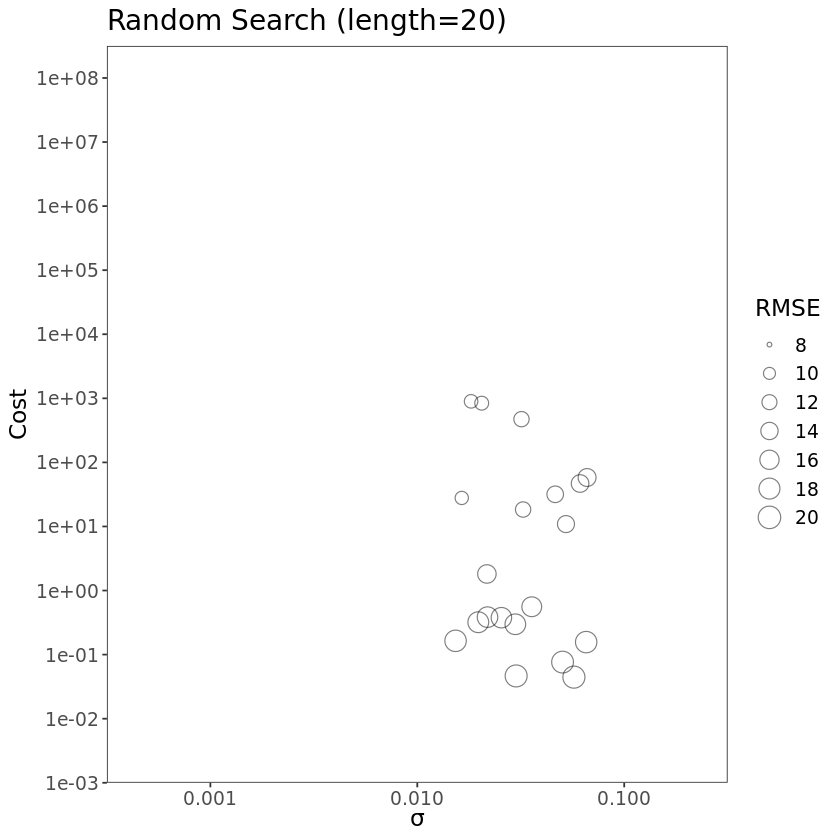

In [4]:
library(tidyverse)
## Generating the RMSE plots using the two hyperparameters as the x (sigma) and y (Cost) axis.
random_search$results %>% ggplot(aes(sigma, C)) +
    geom_point(aes(size = RMSE), shape = 21, alpha = 0.5) + 
    coord_cartesian(ylim = c(10^(-3),10^8.5), xlim = c(10^(-3.5),10^(-0.5)), expand = F) +
    scale_x_log10(breaks = 10^(seq(-4,0,1))) + 
    scale_y_log10(breaks = 10^(seq(-3,9,1))) + 
    scale_size_continuous(breaks = seq(8,20,2), limits = c(8,20)) + 
    labs(x = expression(sigma), y = "Cost", parse=T, title = "Random Search (length=20)") +
    theme_bw() +
    theme(panel.grid = element_blank(), text = element_text(size = 14))

In [5]:
## We can further look at the final model from the random search and its best model
## hyperparameters
print("======================")
print("Best (C. sigma) based on random search is: ")
print(random_search$bestTune)
print("======================")
getTrainPerf(random_search)

[1] "======================"
[1] "Best (C. sigma) based on random search is: "
       sigma        C
2 0.01640194 27.86738
[1] "======================"


TrainRMSE,TrainRsquared,TrainMAE,method
<dbl>,<dbl>,<dbl>,<chr>
10.75293,0.7193238,8.377613,svmRadial


From the scatter plot, we see that random search is not the most efficient way of tuning the hyperparameter,
especially when there is a very wide range of possible combinations. This problem can be extremely challenging
for more complex models (e.g., deep learning models) with nearly a half dozen hyperparameters need to be pre-
determined by us. But random search can give us a starting point as an initial guess.

Now with the random search restulst, we naively assume that the optimum hyperparameter combination may appear 
in the center region in the hyperparameter space. What should we do next? 

## Grid Search

We can try to refine our search in the "suspect" optimal hyperparameter space with a fine grid to make sure we
can get close to the optimal combination under our assumption (that the optimal values exist in this narrow 
region). 

In [6]:
## Define the hyperparameter grid within a narrower range
parameter_grid <- expand.grid(C = 10^(seq(1,3,0.25)),
                              sigma = 10^(seq(-2.5,-1.5,0.2)))
## There are totally 54 different combinations of C & sigma for the RBF SVM model
sprintf("Totoal number of hyperparameter combinations: %d", nrow(parameter_grid))

## Define the trainControl for grid search with the same repeated CV
grid_ctrl <- trainControl(method = "repeatedcv", repeats = 3,
                          search = "grid")

## Set seed number to make sure the results are reproducible 
set.seed(308) 
## Perform training of a SVM model with RFG kernal with 20 random hyperparameters
## by specificying the "tuneLength" keyword.
grid_search <- caret::train(y ~ ., data = train_data,
                            method = "svmRadial",
                            ## using the predefined parameter grid
                            tuneGrid = parameter_grid,
                            metric = "RMSE",
                            preProc = c("center", "scale"),
                            trControl = grid_ctrl)
## Examine the training SVM model performance with different hyperparameters
grid_search

[1] "Totoal number of hyperparameter combinations: 54"

Support Vector Machines with Radial Basis Function Kernel 

250 samples
 20 predictor

Pre-processing: centered (20), scaled (20) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 226, 225, 226, 225, 225, 223, ... 
Resampling results across tuning parameters:

  C           sigma        RMSE       Rsquared   MAE      
    10.00000  0.003162278  17.179637  0.2934535  12.802734
    10.00000  0.005011872  16.229726  0.3739360  12.164676
    10.00000  0.007943282  14.464492  0.5109845  10.947883
    10.00000  0.012589254  12.499203  0.6361589   9.586778
    10.00000  0.019952623  11.492068  0.6890802   8.845501
    10.00000  0.031622777  12.196266  0.6540070   9.402476
    17.78279  0.003162278  16.577732  0.3438798  12.384535
    17.78279  0.005011872  15.116297  0.4604594  11.448387
    17.78279  0.007943282  12.836959  0.6158558   9.860838
    17.78279  0.012589254  11.134842  0.7054385   8.579822
    17.78279  0.019952623  11.118835  0.7036153   8.63749

We can put this results into the perspective by comparing with our random search results.

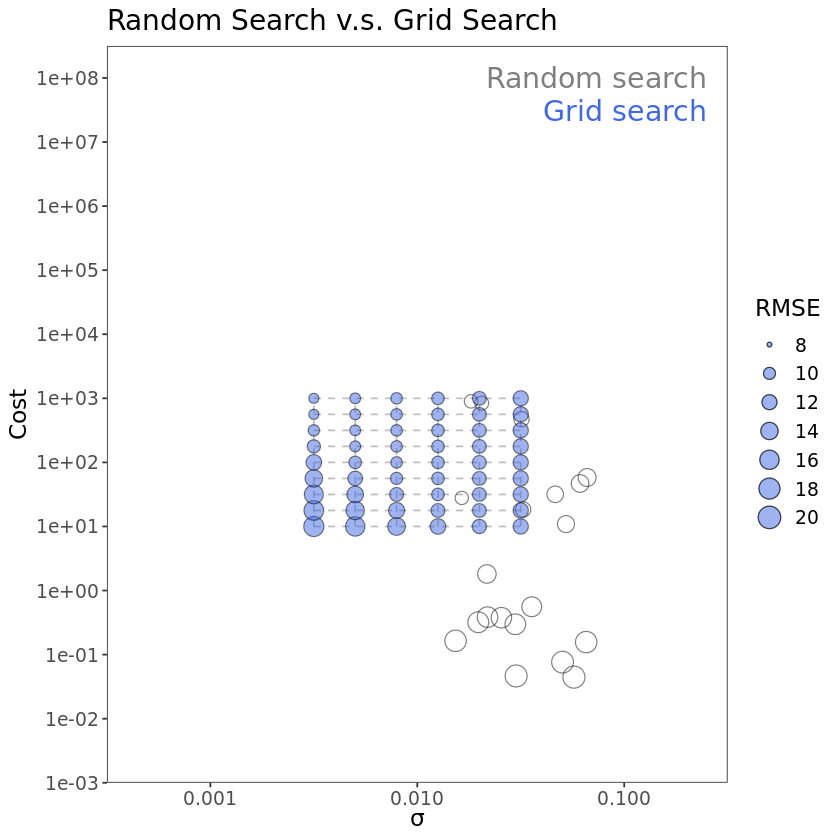

In [7]:
## Generating the RMSE plots using the two hyperparameters as the x (sigma) and y (Cost) axis.
## adding blue points for grid search
ggplot() + 
    ## identify the grid on the hyperparameter space
    annotate("segment", y = 10^(seq(1,3,0.25)), yend = 10^(seq(1,3,0.25)), 
             x = 10^(-2.5), xend = 10^(-1.5), color = "grey50", alpha=0.5, linetype = 2) +
    annotate("segment", y = 10, yend = 10^3, x = 10^(seq(-2.5,-1.5,0.2)), 
             xend = 10^(seq(-2.5,-1.5,0.2)), color = "grey50", alpha=0.5, linetype = 2) +
    ## Plot scatter plot for random search
    geom_point(aes(sigma, C, size = RMSE), shape = 21, alpha = 0.5, data = random_search$results) +
    annotate("text", x = 10^(-0.6), y = 10^8, label = "Random search", color = "grey50", size = 6, hjust = 1) +
    ## Plot scatter plot for grid search with different fill color
    geom_point(aes(sigma, C, size = RMSE), shape = 21, alpha = 0.5, fill="royalblue", 
               data = grid_search$results) +
    annotate("text", x = 10^(-0.6), y = 10^7.5, label = "Grid search", color = "royalblue", size = 6, hjust = 1) +
    ## Define the coordinate system and other parts of the figure
    coord_cartesian(ylim = c(10^(-3),10^8.5), xlim = c(10^(-3.5),10^(-0.5)), expand = F) +
    scale_x_log10(breaks = 10^(seq(-4,0,1))) + 
    scale_y_log10(breaks = 10^(seq(-3,9,1))) + 
    scale_size_continuous(breaks = seq(8,20,2), limits = c(8,20)) + 
    labs(x = expression(sigma), y = "Cost", parse = T, title = "Random Search v.s. Grid Search") +
    theme_bw() +
    theme(panel.grid = element_blank(), text = element_text(size = 14))

From the above plot, we see slight improvements of the training results of the grid search. Assuming that we
have enough computational power and we can search through the entire hyperparameter space with fine grid, we
could potentially find the most appropriate hyperparameter. But as you have imagined, it will be very costly
for model training. This is when **Bayesian Optimization** comes to rescue. 

## Bayesian Optimization  

Bayesian Optimization is an optimization scheme that uses Bayesian models based on Gaussian processes to 
predict good tuning parameters. More specifically, we can create a regression model to formalize the 
relationship between the outcome (RMSE, in this notebook) and the SVM tuning parameters(i.e., `cost` and 
`sigma`). The standard assumption regarding normality of the residuals is used and, being a Bayesian model, 
the regression parameters also gain a prior distribution that is multivariate normal. The Gaussian process  
model uses a kernel basis expansion (much like the SVM model does) in order to allow the model to be nonlinear
in the SVM tuning parameters. To do this, a RBF kernel is used for the covariance function of the multivariate
normal prior and maximum likelihood is used to estimate the kernel parameters of the Gaussian process.

In the end, the  Gaussian process regression model can take the current set of resampled RMSE values and make 
predictions over the entire space of potential `cost` and `sigma` parameters. The Bayesian theory allows of this 
prediction to have a distribution; for a given set of tuning parameters, we can obtain the estimated mean RMSE
values as well as an estimate of the corresponding prediction variance.

To carry out the Bayesian Optimization for our SVM model development, we will take advantage of the R package 
`rBayesianOptimization` developed by Yachen Yan (see [package information](https://cran.r-project.org/web/packages/rBayesianOptimization/index.html)). 
In the `rBayesianOptimization` package, we can also use our initial random search as the initial guess to inform our
first GP fit. 

First of all, we need to define the SVM model to be feed into `rBayesianOptimization`. 

In [9]:
## Define the resampling method with the same repeated CV
ctrl <- trainControl(method = "repeatedcv", repeats = 3)
 
## Use this function to optimize the model. The two parameters are 
## evaluated on the log scale given their range and scope. 
svm_fit_bayes <- function(logC, logSigma) {
  ## Use the same model code but for a single (C, sigma) pair. 
  txt <- capture.output(
  mod <- caret::train(y ~ ., data = train_data,
                 method = "svmRadial",
                 preProc = c("center", "scale"),
                 metric = "RMSE",
                 trControl = ctrl,
                 tuneGrid = data.frame(C = exp(logC), 
                                       sigma = exp(logSigma))))
  ## The optimization function wants to _maximize_ the outcome so we return 
  ## the negative of the resampled RMSE value. `Pred` can be used
  ## to return predicted values but we'll avoid that and use zero
  list(Score = -getTrainPerf(mod)[, "TrainRMSE"], Pred = 0)
}
 
## Define the bounds of the search. 
lower_bounds <- c(logC = -5, logSigma = -9)
upper_bounds <- c(logC = 20, logSigma = -0.75)
bounds <- list(logC = c(lower_bounds[1], upper_bounds[1]),
               logSigma = c(lower_bounds[2], upper_bounds[2]))

In order to use our original random search results as the initial guess for the optimization, we will
first define the initial grid and them start the Bayesian Optimization using function `BayesianOptimization`.  

In [10]:
## Create a grid of values as the input into the BO code
initial_grid <- random_search$results[, c("C", "sigma", "RMSE")]
initial_grid$C <- log(initial_grid$C)
initial_grid$sigma <- log(initial_grid$sigma)
initial_grid$RMSE <- -initial_grid$RMSE
names(initial_grid) <- c("logC", "logSigma", "Value")

## Run the optimization with the initial grid and do
## 30 iterations. We will choose new parameter values
## using the upper confidence bound using 1 std. dev. 

library(rBayesianOptimization)
## Set seed number to ensure reproducible results 
set.seed(8606)
ba_search <- BayesianOptimization(svm_fit_bayes,
                                  bounds = bounds,
                                  ### need initial grid to kick off the optimization
                                  ### here we use the random search results
                                  init_grid_dt = initial_grid, 
                                  init_points = 0, 
                                  n_iter = 25,
                                  ### Choose acquisition function
                                  ## here we use the UCB
                                  ## you can change it to others as well
                                  acq = "ucb", 
                                  kappa = 1, 
                                  eps = 0.0,
                                  verbose = TRUE)

20 points in hyperparameter space were pre-sampled
elapsed = 3.27	Round = 21	logC = 5.9409	logSigma = -5.2505	Value = -9.5790 
elapsed = 2.91	Round = 22	logC = 6.7589	logSigma = -5.4700	Value = -9.2515 
elapsed = 2.37	Round = 23	logC = 6.5978	logSigma = -5.2862	Value = -9.4750 
elapsed = 4.75	Round = 24	logC = 8.9428	logSigma = -6.0208	Value = -9.2056 
elapsed = 1.54	Round = 25	logC = 5.4697	logSigma = -7.3236	Value = -17.2394 
elapsed = 5.01	Round = 26	logC = 7.7212	logSigma = -6.0708	Value = -9.0012 
elapsed = 3.87	Round = 27	logC = 7.9527	logSigma = -5.8361	Value = -9.4948 
elapsed = 12.32	Round = 28	logC = 10.7484	logSigma = -6.7619	Value = -8.9129 
elapsed = 12.71	Round = 29	logC = 9.5793	logSigma = -6.6642	Value = -8.8089 
elapsed = 5.99	Round = 30	logC = 11.2316	logSigma = -6.0821	Value = -9.0775 
elapsed = 7.38	Round = 31	logC = 10.3255	logSigma = -6.3777	Value = -8.5983 
elapsed = 4.23	Round = 32	logC = 6.5718	logSigma = -6.0361	Value = -9.0326 
elapsed = 13.03	Round = 33	logC

Now, we can add the Bayesian Optmization searched through hyperparameter combination to our
scatter plot.

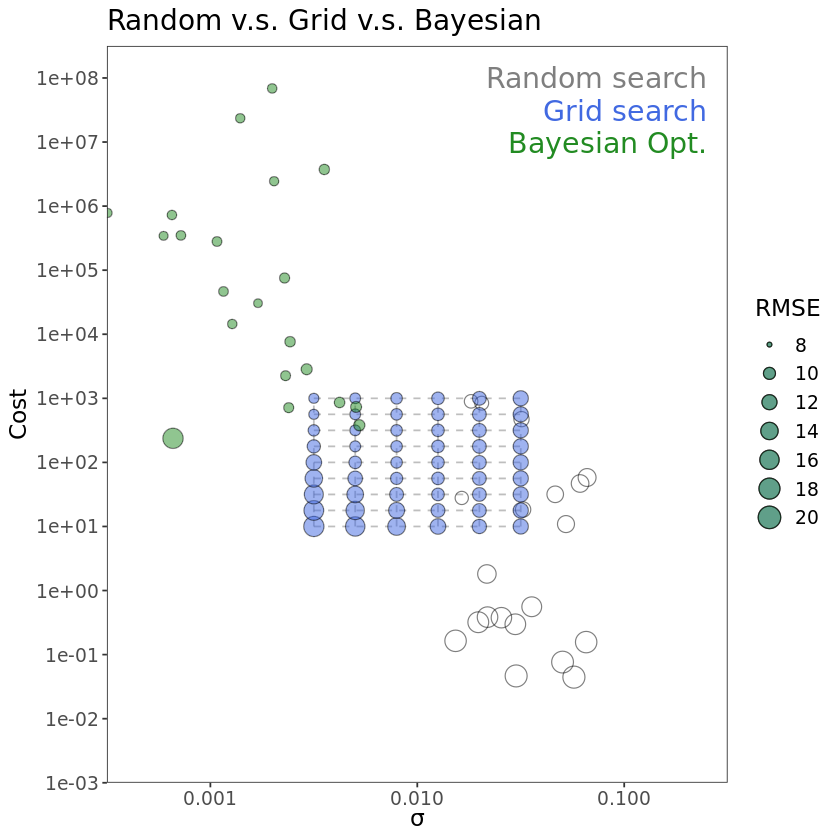

In [11]:
## Get the information
bayes_history <- data.frame(
  C = exp(ba_search$History$logC),
  sigma = exp(ba_search$History$logSigma),
  RMSE = - ba_search$History$Value
)

## Generating the RMSE plots using the two hyperparameters as the x (sigma) and y (Cost) axis.
## adding blue points for grid search
ggplot() + 
    ## identify the grid on the hyperparameter space
    annotate("segment", y = 10^(seq(1,3,0.25)), yend = 10^(seq(1,3,0.25)), 
             x = 10^(-2.5), xend = 10^(-1.5), color = "grey50", alpha=0.5, linetype = 2) +
    annotate("segment", y = 10, yend = 10^3, x = 10^(seq(-2.5,-1.5,0.2)), 
             xend = 10^(seq(-2.5,-1.5,0.2)), color = "grey50", alpha=0.5, linetype = 2) +
    ## Plot scatter plot for random search
    geom_point(aes(sigma, C, size = RMSE), shape = 21, alpha = 0.5, data = random_search$results) +
    annotate("text", x = 10^(-0.6), y = 10^8, label = "Random search", color = "grey50", size = 6, hjust = 1) +
    ## Plot scatter plot for grid search with different fill color
    geom_point(aes(sigma, C, size = RMSE), shape = 21, alpha = 0.5, fill="royalblue", 
               data = grid_search$results) +
    annotate("text", x = 10^(-0.6), y = 10^7.5, label = "Grid search", color = "royalblue", size = 6, hjust = 1) +
    ## Plot scatter plot for grid search with different fill color
    geom_point(aes(sigma, C, size = RMSE), shape = 21, alpha = 0.5, fill="forestgreen", 
               data = bayes_history[21:nrow(bayes_history),]) +
    annotate("text", x = 10^(-0.6), y = 10^7, label = "Bayesian Opt.", color = "forestgreen", size = 6, hjust = 1) +
    ## Define the coordinate system and other parts of the figure
    coord_cartesian(ylim = c(10^(-3),10^8.5), xlim = c(10^(-3.5),10^(-0.5)), expand = F) +
    scale_x_log10(breaks = 10^(seq(-4,0,1))) + 
    scale_y_log10(breaks = 10^(seq(-3,9,1))) + 
    scale_size_continuous(breaks = seq(8,20,2), limits = c(8,20)) + 
    labs(x = expression(sigma), y = "Cost", parse = T, title = "Random v.s. Grid v.s. Bayesian") +
    theme_bw() +
    theme(panel.grid = element_blank(), text = element_text(size = 14)) 

The final settings were found with a large `cost` setting and a very small `sigma` data value. We would
have never thought to evaluate a `cost` parameter so large and the algorithm wants to make it even larger.
Does it really work?

We can fit a model based on the new configuration and compare it to random search in terms of the resampled
RMSE and the RMSE on the test set:

In [12]:
set.seed(308)
bayes_search <- caret::train(y ~ ., data = train_data,
                      method = "svmRadial",
                      ## Use the best parameter found in the Bayesian Optimizer
                      ## for our final SVM model
                      tuneGrid = data.frame(C = exp(ba_search$Best_Par["logC"]), 
                                            sigma = exp(ba_search$Best_Par["logSigma"])),
                      metric = "RMSE",
                      preProc = c("center", "scale"),
                      trControl = ctrl)

Let's see the comparison between *random search* and *bayesian optimization*.

In [13]:
compare_models(bayes_search, random_search)



	One Sample t-test

data:  x
t = -9.4828, df = 29, p-value = 2.171e-10
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -2.779088 -1.792995
sample estimates:
mean of x 
-2.286042 


Same with the *grid search* result!

In [14]:
compare_models(bayes_search, grid_search)



	One Sample t-test

data:  x
t = -5.7721, df = 29, p-value = 2.982e-06
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.7915542 -0.3773684
sample estimates:
 mean of x 
-0.5844613 


We can compare the final model from three different parameter tuning strategies using a different dataset for evaluation.

In [15]:
## Random Search
postResample(predict(random_search, large_data), large_data$y)
## Grid Search
postResample(predict(grid_search, large_data), large_data$y)
## Bayesian Optimization
postResample(predict(bayes_search, large_data), large_data$y)

RMSE   Rsquared        MAE 
10.5033877  0.7791881  7.8106620

RMSE  Rsquared       MAE 
8.5029361 0.8411853 6.5474409

RMSE  Rsquared       MAE 
8.0532700 0.8540448 6.1936740

It appears that the Bayesian Optimization based SVM model outperforms both the random search
and grid search.

## Exercise

Now we have reviewed how to perform random search, grid search, and Bayesian Optimization for hyperparameter tuning. But we only did it with an simulated data. Now it is your term to apply it to your data and model. You can choose a model we discussed in the past, such as, Neural Network, SVM, random forest, etc. 